# Multivariable coarse phase diagram protocol

In [2]:
from opentrons import simulate, execute
from opentrons.types import Location, Point

import numpy as np
import pandas as pd
import time
import math
# import matplotlib.pyplot as plt
from IPython.display import clear_output
from copy import copy

import pandas as pd

api_level= '2.11'

In [6]:
df = pd.read_csv("22_02_15_EWSRI.csv", delimiter=";", encoding="latin-1")
df = df.set_index(df["Which"])
df = df.fillna(0)
df = df.drop("Which", axis=1)
df

,Protein c1,Protein c2,Protein c3,Protein c4,Normal buffer,Salt buffer c1,Salt buffer c2,Salt buffer c3,Salt buffer c4,HCl pH1,HCl pH2,HCl pH3,DNA,Urea,Water
Which,,,,,,,,,,,,,,,
Starting concentration in M,0.00002,0,0,0,0,0.5,0.00,0.00,0.0,7.748,0,0,0.001,0.5,0
Starting volume in µl,0,0,0,0,0,0,0.00,0.00,0.0,0,0,0,0,0,0
End concentrations in M,3.7037E-06,0.0000162,0.0000081,0.0000162,0,0.5,0.25,0.15,0.1,0,0,0,0,0,0
desired pH,0,0,0,0,8.5,8.5,0.00,0.00,0.0,8.5,7.5,6.5,0.001,0,0
Labware,eppi_rack,eppi_rack,eppi_rack,reservoir,reservoir,reservoir,0.00,0.00,0.0,eppi_rack,eppi_rack,eppi_rack,eppi_rack,eppi_rack,reservoir
Well,A1,A2,A3,A2,A1,A2,0.00,0.00,0.0,B1,B2,B3,D1,D2,A3
Well volume,5,5,5,5,20,20,20.00,20.00,20.0,1,1,1,1,1,0
NaN,0,0,0,0,0,0,0.00,0.00,0.0,0,0,0,0,0,0
Maximum concentration,3.7037E-06,0,0,0,0,0,0.00,0.00,0.0,0,0,0,0,0,0


In [7]:
# convert type to float
for key in ["Starting concentration in M", "Starting volume in µl", "End concentrations in M", "desired pH"]:
    df.loc[key].apply(float)

In [8]:
class Fluid:
    def __init__(self, name, labware, well, well_volume=0, c = 0, pH = None, c_dil = 0):
        self.name = name
        self.pos = None
        self.well_volume = float(well_volume) if well_volume is not None else 0
        self.c = float(c)
        self.c_dil = float(c)
        self.pH = float(pH) if pH is not None else None
        self.set_deck_location(labware, well)
        self.v = float(0)
        
    def set_deck_location(self,labware, well):
        if (labware == None) | (labware == 0) | (well== None) | (well == 0) : 
            return
        loc = globals()[labware][well]
        self.pos = loc
        
    def __repr__(self):
        return str({
            "name": self.name,
            "pos": self.pos,
            "well_volume": self.well_volume,
            "c": self.c,
            "pH": self.pH,
            "v" : self.v
        })

In [9]:
class Parameter:
    def __init__(self, name, stock, fluids):
        self.name = name
        self.stock = stock
        self.fluids = fluids
        
    def __repr__(self):
        return str({
            "name": self.name,
            "stock": self.stock,
            "fluids": self.fluids,
        })

# Protocol

In [10]:
protocol = simulate.get_protocol_api(api_level)

protocol.home()

C:\Users\raras\.opentrons\robot_settings.json not found. Loading defaults
C:\Users\raras\.opentrons\deck_calibration.json not found. Loading defaults


# Layout

<table style="width:300px;">
    <tr><td>10</td><td>11</td><td>trash</td></tr>
    <tr><td>7 <br> tube rack</td><td>8 <br> tips 20</td><td>9 <br> tips 20</td></tr>
    <tr><td>4 </td><td>5 <br> plate </td><td>6 <br> eppi rack</td></tr>
    <tr><td>1 <br> tips 300</td><td>2 <br> reservoir</td><td>3</td></tr>
    
</table>

In [11]:
tips_300 = protocol.load_labware("opentrons_96_tiprack_300ul", 1)

reservoir = protocol.load_labware("nest_12_reservoir_15ml", 2)

tips_20 = [protocol.load_labware("opentrons_96_filtertiprack_20ul", 8),
           protocol.load_labware("opentrons_96_filtertiprack_20ul", 9)
          ]

plate = protocol.load_labware("corning_384_wellplate_112ul_flat", 5)

tube_rack = protocol.load_labware("opentrons_10_tuberack_falcon_4x50ml_6x15ml_conical", 7)

eppi_rack = protocol.load_labware("opentrons_24_tuberack_eppendorf_1.5ml_safelock_snapcap", 6)

# pcr_tubes_plate = protocol.load_labware("opentrons_96_aluminumblock_generic_pcr_strip_200ul", 2)

In [12]:
pip = protocol.load_instrument("p20_single_gen2", "right", tip_racks=tips_20)
pip300  = protocol.load_instrument("p300_single_gen2", "left", tip_racks=[tips_300])

In [13]:
# pip.starting_tip = tips_20.well("C1")
pip300.starting_tip = tips_300.well("E1")

# Parse Protein

In [14]:
protein_keys = [c for c in df if c.startswith('Protein')]

protein_solutions = []

for key in protein_keys:

    labware = df.loc["Labware", key]
    well = df.loc["Well", key]
    c = df.loc["End concentrations in M", key]
    well_volume = df.loc["Well volume", key]

    protein_solution = Fluid(key, labware, well, well_volume, c)
   
    c0 =  df.loc["Starting concentration in M", key]    
    
    protein_solutions.append(protein_solution)
    if c0 != 0:
        stock = copy(protein_solution)

protein = Parameter("Protein", stock, protein_solutions)

In [15]:
protein

{'name': 'Protein', 'stock': {'name': 'Protein c1', 'pos': A1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 3.7037e-06, 'pH': None, 'v': 0.0}, 'fluids': [{'name': 'Protein c1', 'pos': A1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 3.7037e-06, 'pH': None, 'v': 0.0}, {'name': 'Protein c2', 'pos': A2 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 1.62e-05, 'pH': None, 'v': 0.0}, {'name': 'Protein c3', 'pos': A3 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 8.1e-06, 'pH': None, 'v': 0.0}, {'name': 'Protein c4', 'pos': A2 of NEST 12 Well Reservoir 15 mL on 2, 'well_volume': 5.0, 'c': 1.62e-05, 'pH': None, 'v': 0.0}]}

In [16]:
3.996e-06 * 5/27

7.400000000000001e-07

# Parse Buffer

In [17]:
#  Normal buffer

labware = df.loc["Labware", "Normal buffer"]
well = df.loc["Well", "Normal buffer"]
well_volume = df.loc["Well volume", "Normal buffer"]

normal_buffer = Fluid("Normal buffer", labware, well, well_volume, c = 0)
          

# Salt buffer

salt_keys = [c for c in df if c.startswith('Salt')]

salt_buffer_list = []
for key in salt_keys:
    c = df.loc["End concentrations in M", key]
    well_volume = df.loc["Well volume", key]
    labware = df.loc["Labware", key]
    well = df.loc["Well", key]
    
    buffer = Fluid(key, labware, well, well_volume, c)

    salt_buffer_list.append(buffer)
    
    c0 =  df.loc["Starting concentration in M", key]    

    if c0 != 0:
        stock = buffer
salt_buffers = Parameter("salt", stock, salt_buffer_list)

In [18]:
salt_buffers

{'name': 'salt', 'stock': {'name': 'Salt buffer c1', 'pos': A2 of NEST 12 Well Reservoir 15 mL on 2, 'well_volume': 20.0, 'c': 0.5, 'pH': None, 'v': 0.0}, 'fluids': [{'name': 'Salt buffer c1', 'pos': A2 of NEST 12 Well Reservoir 15 mL on 2, 'well_volume': 20.0, 'c': 0.5, 'pH': None, 'v': 0.0}, {'name': 'Salt buffer c2', 'pos': None, 'well_volume': 20.0, 'c': 0.25, 'pH': None, 'v': 0.0}, {'name': 'Salt buffer c3', 'pos': None, 'well_volume': 20.0, 'c': 0.15, 'pH': None, 'v': 0.0}, {'name': 'Salt buffer c4', 'pos': None, 'well_volume': 20.0, 'c': 0.1, 'pH': None, 'v': 0.0}]}

# Parse others

In [19]:
water = Fluid("Water", df.loc["Labware", "Water"], df.loc["Well", "Water"])

DNA_stock = Fluid("DNA", 
            df.loc["Labware", "DNA"], 
            df.loc["Well", "DNA"],
           well_volume = df.loc["Well volume", "DNA"])

urea_stock = Fluid("Urea", df.loc["Labware", "Urea"], df.loc["Well", "Urea"],
            well_volume = df.loc["Well volume", "Urea"])

other_params = Parameter("other params", DNA_stock, [copy(normal_buffer), DNA_stock, urea_stock ])
# urea = Parameter("Urea", urea_stock, [copy(normal_buffer),urea_stock])
other_params

{'name': 'other params', 'stock': {'name': 'DNA', 'pos': D1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 0.0, 'pH': None, 'v': 0.0}, 'fluids': [{'name': 'Normal buffer', 'pos': A1 of NEST 12 Well Reservoir 15 mL on 2, 'well_volume': 20.0, 'c': 0.0, 'pH': None, 'v': 0.0}, {'name': 'DNA', 'pos': D1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 0.0, 'pH': None, 'v': 0.0}, {'name': 'Urea', 'pos': D2 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 0.0, 'pH': None, 'v': 0.0}]}

# Parse HCl

In [20]:
acid_keys = [c for c in df if c.startswith('HCl')]


acids_list = []
for key in acid_keys:
    
    labware = df.loc["Labware", key]
    well = df.loc["Well", key]    
    pH = df.loc["desired pH", key]
    
    
    well_volume = df.loc["Well volume", key]
    c0 = df.loc["Starting concentration in M", key]
    
    acid = Fluid(key, labware, well, well_volume, c = c0, pH = pH)
    acids_list.append(acid)
    
    
    if c0 != 0:
        stock = acid
        
acids = Parameter("pH", stock, acids_list)
acids

{'name': 'pH', 'stock': {'name': 'HCl pH1', 'pos': B1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 7.748, 'pH': 8.5, 'v': 0.0}, 'fluids': [{'name': 'HCl pH1', 'pos': B1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 7.748, 'pH': 8.5, 'v': 0.0}, {'name': 'HCl pH2', 'pos': B2 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 0.0, 'pH': 7.5, 'v': 0.0}, {'name': 'HCl pH3', 'pos': B3 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 0.0, 'pH': 6.5, 'v': 0.0}]}

# Create grid

In [21]:
shape = [len(protein.fluids), len(salt_buffers.fluids), len(acids.fluids), len(other_params.fluids),]
shape_2d = (shape[0] * shape[2], shape[1]*shape[3])

n_wells = 1
for n in shape:
    n_wells = n * n_wells

In [22]:
wells = np.array(plate.wells()).reshape(24,16).swapaxes(0,1)
all_wells = wells[2:shape_2d[0]+2,3:shape_2d[1]+3]

In [23]:
wells_mask = np.full(all_wells.shape, False)

In [24]:
final_well_volume = 0
for param in [salt_buffers, acids, other_params, protein]:
    final_well_volume = final_well_volume + param.stock.well_volume
print(f'The final volume per well is {final_well_volume}')

The final volume per well is 27.0


In [25]:
min_volume_per_c = protein.stock.well_volume * n_wells / len(protein.fluids)
volume_per_pc = min_volume_per_c + (2 * protein.stock.well_volume)

protein.stock.v = 0
for p in protein.fluids:
    v = volume_per_pc * p.c / protein.stock.c
    print(p.c)
    p.v = v
#     print(p.c * p.well_volume / final_well_volume)
    
    protein.stock.v = protein.stock.v + v
print(f'We need at least {protein.stock.v:.2f} µl of protein stock')

3.7037e-06
1.62e-05
8.1e-06
1.62e-05
We need at least 2267.65 µl of protein stock


In [26]:
protein.fluids

[{'name': 'Protein c1', 'pos': A1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 3.7037e-06, 'pH': None, 'v': 190.0},
 {'name': 'Protein c2', 'pos': A2 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 1.62e-05, 'pH': None, 'v': 831.0608310608311},
 {'name': 'Protein c3', 'pos': A3 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 8.1e-06, 'pH': None, 'v': 415.53041553041555},
 {'name': 'Protein c4', 'pos': A2 of NEST 12 Well Reservoir 15 mL on 2, 'well_volume': 5.0, 'c': 1.62e-05, 'pH': None, 'v': 831.0608310608311}]

In [27]:
protein

{'name': 'Protein', 'stock': {'name': 'Protein c1', 'pos': A1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 3.7037e-06, 'pH': None, 'v': 2267.6520776520774}, 'fluids': [{'name': 'Protein c1', 'pos': A1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 3.7037e-06, 'pH': None, 'v': 190.0}, {'name': 'Protein c2', 'pos': A2 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 1.62e-05, 'pH': None, 'v': 831.0608310608311}, {'name': 'Protein c3', 'pos': A3 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 5.0, 'c': 8.1e-06, 'pH': None, 'v': 415.53041553041555}, {'name': 'Protein c4', 'pos': A2 of NEST 12 Well Reservoir 15 mL on 2, 'well_volume': 5.0, 'c': 1.62e-05, 'pH': None, 'v': 831.0608310608311}]}

## Helper functions:

In [541]:
# def blockshaped(arr, nrows, ncols):
#     """
#     Return an array of shape (n, nrows, ncols) where
#     n * nrows * ncols = arr.size

#     If arr is a 2D array, the returned array should look like n subblocks with
#     each subblock preserving the "physical" layout of arr.
#     """
#     h, w = arr.shape
#     assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
#     assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
#     return (arr.reshape(h//nrows, nrows, -1, ncols)
#                .swapaxes(1,2)
#                .reshape(-1, nrows, ncols))
draw = True
def draw_progress(well_mask):
    if draw:
        plt.axis('off');
        ax = plt.imshow(well_mask);
        plt.close(0)
        ax.set_data(well_mask)
        #             clear_output()
        fig = plt.gcf()
        fig.canvas.draw();
        fig.canvas.flush_events();
        plt.show(0);
            

If we want to simulate:

In [542]:
well_dict = dict.fromkeys(list(all_wells.flatten()))

In [543]:
# wells_blockshaped = blockshaped(wells_to_fill, 2, 3)

## For visualization:

In [544]:
# wells_reshaped = np.array(plate.wells()).reshape((24,16)).swapaxes(0,1)[2:14, 2:10]
# well_mask = np.full(wells_reshaped.shape, False)

# Buffers:

Buffer volumes:

In [545]:
for buffer in salt_buffers.fluids:
#     buffer.c = (c * 20 + 0.5 * 6) / final_well_volume
    c_actual = (buffer.c * final_well_volume - 0.5 * 6 ) / buffer.well_volume
    v = c_actual * buffer.well_volume / salt_buffers.stock.c
    if v < 1:
        v = 1
#         c_actual = v * salt_buffers.stock.c / buffer.well_volume
        print(f'Salt concentration for {buffer.name} will be higher.')
    if v > 20:
        v = 20
#         c_actual = v * salt_buffers.stock.c / buffer.well_volume
        print(f'Salt concentration for {buffer.name} will be lower.')
    print(v)
    buffer.v = v
# salt_buffers

Salt concentration for Salt buffer c1 will be lower.
20
7.5
2.0999999999999996
Salt concentration for Salt buffer c4 will be higher.
1


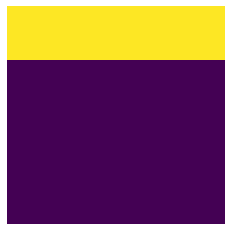

Pipetting 0.0 µl of Normal buffer


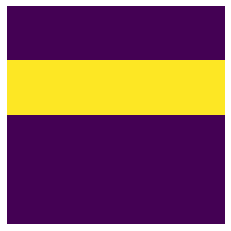

Pipetting 12.5 µl of Normal buffer


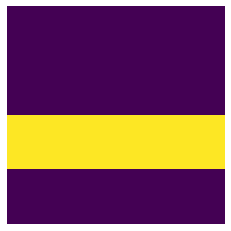

Pipetting 17.9 µl of Normal buffer


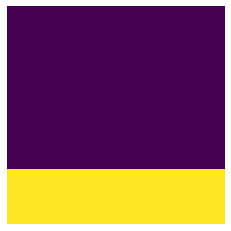

Pipetting 19.0 µl of Normal buffer


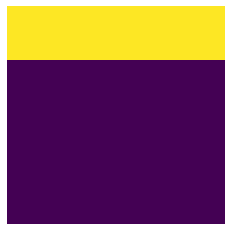

Pipetting 20 µl of Salt buffer c1


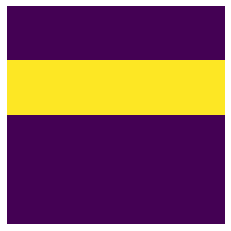

Pipetting 7.5 µl of Salt buffer c1


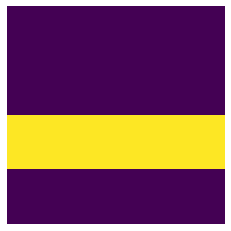

Pipetting 2.0999999999999996 µl of Salt buffer c1


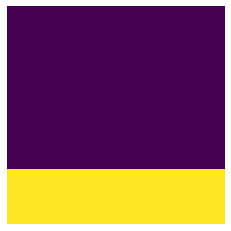

Pipetting 1 µl of Salt buffer c1


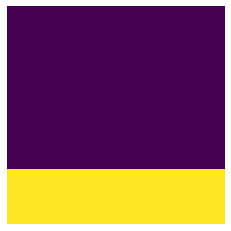

In [546]:
if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip()

# Loop through buffers
for buffer in (normal_buffer, salt_buffers.stock):
                
    for i, b in enumerate(salt_buffers.fluids):
        
        v = b.v
        if buffer.name == "Normal buffer":
            v = b.well_volume - v
    
        from_row = (i * len(acids.fluids)) 
        to_row = from_row + len(acids.fluids)
        to_column = (len(salt_buffers.fluids) * len(acids.fluids)) 

        
        wells_mask[:] = False
        wells_mask[from_row:to_row, 0:to_column] = True
        draw_progress(wells_mask)
        
        print(f'Pipetting {v} µl of {buffer.name}')
      
           
        wells = list(all_wells[wells_mask])
        
        for well in wells:
            well_dict[well] = {"v": v,
                                      "name": "salt"}
        
        if v < 9.5:
            pip.distribute(v, 
                         buffer.pos, 
                         wells,
                         new_tip="never"
                        )
            
        else:
            if v != 0: # otherwise it will pipette the pip's max volume!!!
                for well in wells:
                    pip.aspirate(v,
                                buffer.pos)
                    pip.dispense(v,
                                well)
        
            

#        

In [547]:
pip.drop_tip()

<InstrumentContext: p20_single_v2.0 in RIGHT>

In [548]:
for line in protocol.commands():
    print(line)
protocol.clear_commands()

Picking up tip from A1 of Opentrons 96 Filter Tip Rack 20 µL on 8
Distributing 0.0 from A1 of NEST 12 Well Reservoir 15 mL on 2 to C4 of Corning 384 Well Plate 112 µL Flat on 5
Transferring 0.0 from A1 of NEST 12 Well Reservoir 15 mL on 2 to C4 of Corning 384 Well Plate 112 µL Flat on 5
Aspirating 12.5 uL from A1 of NEST 12 Well Reservoir 15 mL on 2 at 7.56 uL/sec
Dispensing 12.5 uL into F4 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Aspirating 12.5 uL from A1 of NEST 12 Well Reservoir 15 mL on 2 at 7.56 uL/sec
Dispensing 12.5 uL into F5 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Aspirating 12.5 uL from A1 of NEST 12 Well Reservoir 15 mL on 2 at 7.56 uL/sec
Dispensing 12.5 uL into F6 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Aspirating 12.5 uL from A1 of NEST 12 Well Reservoir 15 mL on 2 at 7.56 uL/sec
Dispensing 12.5 uL into F7 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Aspirating 12.5 uL from A1 of NEST 12 Well Reservoir 15 

In [481]:
pip.drop_tip()

NoTipAttachedError: Cannot perform DROPTIP without a tip attached

# pH

$
    pH = pK_{a} - log(\frac{[HA]}{[A^-]})
$

$
    pK_{a, TRIS, 25°C} = 8.1
$

For a 50 mM Tris-Buffer at pH 8.5, we have 50 mM Tris and 14.71 mM HCl.
I.e. 35.29 mM Tris base and 14.71 conjugated acid.

In [414]:
# 10**(pKa-8.5) * base # = acid

# 50 = base + 10**(pKa-8.5) * base
base = 50/(1+10**(pKa-7.4))
50-base

41.99753473173766

### Calculations:

In [482]:
# Some variables:
pHs = np.arange(0,12, 0.1)
pKa = 8.12
base = (35.29 *10**-3 * 21 + 8.00 *10**-3 * 5)/27 # M
acid = (14.71 *10**-3 * 21 + 42.00 *10**-3 * 5)/27# M # HERE the 20 was missing for run on 10.2.22
# c0_HCl = 12.1 # M = 37.2%
# V_well = 26 * 10**-6
# V_to_pipette = 1 * 10**-6 # µl

In [483]:
pKa - math.log10((0.519+0.504)/(0.781-0.504))

7.552604135352287

In [484]:
# This functions takes in a desired pH and return the amount of HCl needed to achieve that pH
def get_V(pH):
    ratio = 10**(pKa-pH)
    c1_HCl = (ratio * base - acid)/(1+ratio)
    V = (c1_HCl * final_well_volume)/acids.stock.c
    V = V  # return in µl
    return V

# This functions takes in a desired V and returns the concentration of HCl needed to achieve that pH
def get_c(pH):
    ratio = 10**(pKa-pH)
    c1_HCl = (ratio * base - acid)/(1+ratio)
    c = (c1_HCl * final_well_volume)/acids.stock.well_volume
    # return in M
    return c

# Plot the graph, does not work on robot server
# fig, ax = plt.subplots(figsize = (10.5,5.5))
# V_acid = [get_V(pH) for pH in pHs]
# ax.plot(pHs, V_acid, label="V in µl");

# c_acid = [get_c(pH) for pH in pHs]
# ax.plot(pHs, c_acid, label="c in mM");
# ax.set_xlabel("pH")
# ax.legend();

For the adjustment of pH, the plan is to always add 1 µl (minimum working volume of the pipette p20) of acid. 
In order to have different pHs, we prepare 2 differently concentrated HCl stock solutions.

In [485]:
V_min_HCl = len(all_wells.flatten()) * acids.stock.well_volume + 4*acids.stock.well_volume
print(V_min_HCl)

148.0


In [486]:
ratio = ((acid + get_c(acids.fluids[2].pH)*1/27 )  /   (base -get_c(acids.fluids[2].pH)*1/27  ))
pKa - math.log10( ratio)

6.500000000000002

In [487]:
print(f'The first solution needs a concentration of {get_c(acids.fluids[1].pH):.6f} M')
print(f'The second solution needs a concentration of {get_c(acids.fluids[2].pH):.6f} M')

The first solution needs a concentration of 0.529576 M
The second solution needs a concentration of 0.750636 M


In [488]:
# V_HCl_stock = 1000 # µl
acids.fluids[1].v = get_c(acids.fluids[1].pH) * V_min_HCl / (acids.stock.c ) 
acids.fluids[2].v = get_c(acids.fluids[2].pH) * V_min_HCl / (acids.stock.c ) 

print(f'We need {acids.fluids[1].v} µl and {acids.fluids[2].v} µl HCl ')

We need 10.115799611514133 µl and 14.33842107196277 µl HCl 


In [489]:
get_c(acids.fluids[1].pH)

0.5295757796622399

In [490]:
7.748 * 6.505 / 100

0.5040074

### Prepare different HCl solutions
# ADD MIX

In [498]:
if not pip300.hw_pipette["has_tip"]:
    pip300.pick_up_tip()

# for acid in [acids["middle"], acids["low"]]:
#     print(V_HCl_stock - acid["vol"])
#     pip300.transfer(V_HCl_stock - acid["vol"],
#                 water["pos"],
#                    acid["pos"],
#                    new_tip='never')
for acid in [acids.fluids[1], acids.fluids[2]]:
    pip300.transfer(V_min_HCl - acid.v,
                    water.pos,
                    acid.pos,
                    new_tip='never')
pip300.drop_tip()

if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip() 
    
for acid in [acids.fluids[1], acids.fluids[2]]:
    pip.transfer(acid.v,
                    acids.stock.pos,
                    acid.pos,
                    new_tip='never',
#                  mix_after=(5,20)
                )
    
pip.drop_tip()

<InstrumentContext: p20_single_v2.0 in RIGHT>

In [85]:
acids

{'name': 'pH', 'stock': {'name': 'HCl pH1', 'pos': B1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 7.748, 'pH': 8.5, 'v': 0.0}, 'fluids': [{'name': 'HCl pH1', 'pos': B1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 7.748, 'pH': 8.5, 'v': 0.0}, {'name': 'HCl pH2', 'pos': B2 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 0.0, 'pH': 7.5, 'v': 7.202284798260596}, {'name': 'HCl pH3', 'pos': B3 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6, 'well_volume': 1.0, 'c': 0.0, 'pH': 6.5, 'v': 9.332272508021518}]}

In [501]:
for line in protocol.commands():
    print(line)
protocol.clear_commands()

Picking up tip from C1 of Opentrons 96 Filter Tip Rack 20 µL on 8
Distributing 1.0 from A3 of NEST 12 Well Reservoir 15 mL on 2 to L15 of Corning 384 Well Plate 112 µL Flat on 5
Transferring 1.0 from A3 of NEST 12 Well Reservoir 15 mL on 2 to L15 of Corning 384 Well Plate 112 µL Flat on 5
Aspirating 13.0 uL from A3 of NEST 12 Well Reservoir 15 mL on 2 at 7.56 uL/sec
Dispensing 1.0 uL into L15 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into L14 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into L13 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into L12 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into L11 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into L10 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into L9 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into L8 of Corning 

### Pipette 1 µl of HCl in each well:

# Change to water HERE

For pH 8.5 using Water.
Pipetting 1.0 µl Water into these rows:


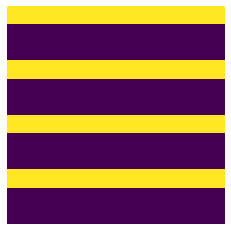

Pipetting 1.0 µl HCl pH2 into these rows:


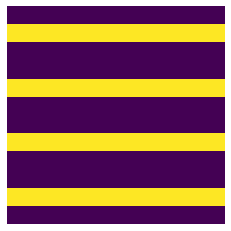

Pipetting 1.0 µl HCl pH3 into these rows:


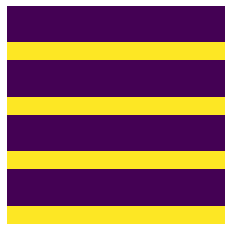

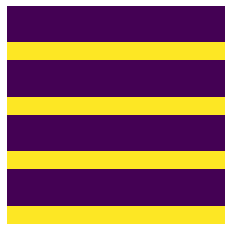

In [500]:
if not pip.hw_pipette["has_tip"]:
    pip.pick_up_tip()


for i, acid in enumerate(acids.fluids):
    
    v = acid.well_volume
    pos = acid.pos
    what = acid.name
    
    
    if acid.pH == 8.5:
        pos = water.pos
        what = water.name
        print(f"For pH 8.5 using {what}.")
    
    
    wells_mask[:] = False
    wells_mask[i::3,0:] = True
    print(f'Pipetting {v} µl {what} into these rows:')
#     print(wells_mask)
    draw_progress(wells_mask)
    
    wells = np.flip(all_wells[wells_mask])
    wells = wells.reshape(-1,12)
#     wells = wells.reshape(12,-1)
   
#     print(wells)
    
    for row in wells:
        row = list(row)
        for well in row:
            well_dict[well]["pH"] = {"v": v,
                                     "name": what}
#             print(f'Pipetting {vol} µl into {well}')
        pip.distribute(acid.well_volume,
                    pos,
                    row,
                    new_tip='never')
        

In [503]:
for line in protocol.commands():
    print(line)
protocol.clear_commands()

Distributing 1.0 from A1 of NEST 12 Well Reservoir 15 mL on 2 to N13 of Corning 384 Well Plate 112 µL Flat on 5
Transferring 1.0 from A1 of NEST 12 Well Reservoir 15 mL on 2 to N13 of Corning 384 Well Plate 112 µL Flat on 5
Aspirating 20.0 uL from A1 of NEST 12 Well Reservoir 15 mL on 2 at 7.56 uL/sec
Dispensing 1.0 uL into N13 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into N10 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into N7 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into N4 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into M13 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into M10 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into M7 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into M4 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL int

In [89]:
pip.drop_tip()

<InstrumentContext: p20_single_v2.2 in RIGHT>

# Add other parameter

Pipetting 1.0 µl Normal buffer into these columns:


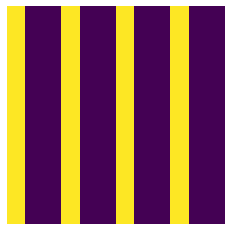

Pipetting 1.0 µl DNA into these columns:


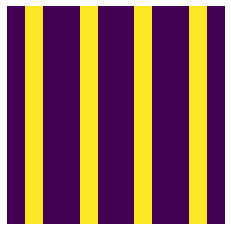

Pipetting 1.0 µl Urea into these columns:


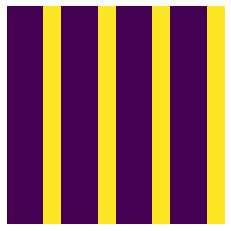

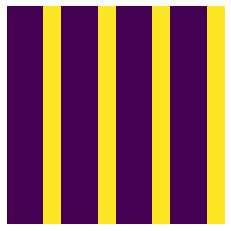

In [505]:
    if not pip.hw_pipette["has_tip"]:
        pip.pick_up_tip()

    for i, fluid in enumerate(other_params.fluids):

        wells_mask[:] = False
        wells_mask[:,i::3] = True
        print(f'Pipetting {other_params.stock.well_volume} µl {fluid.name} into these columns:')
        draw_progress(wells_mask)
        wells = list(np.flip(all_wells[wells_mask]))
        pip.distribute(other_params.stock.well_volume,
                       fluid.pos, 
                       wells, 
                       new_tip='never');

        for well in wells:
            well_dict[well]["Other"] = {"v": fluid.well_volume,
                                  "name": fluid.name}


    # add DNA in every other row
    # for well in wells.flatten():
    # #     print(f'Pipetting {DNA["vol"]} µl into {well}')
    #     pip.aspirate(DNA["vol"],
    #                 DNA["pos"])
    #     pip.dispense(DNA["vol"],
    #                 well)


In [506]:
pip.drop_tip()

<InstrumentContext: p20_single_v2.0 in RIGHT>

In [507]:
for line in protocol.commands():
    print(line)
protocol.clear_commands()

Distributing 1.0 from A1 of NEST 12 Well Reservoir 15 mL on 2 to N13 of Corning 384 Well Plate 112 µL Flat on 5
Transferring 1.0 from A1 of NEST 12 Well Reservoir 15 mL on 2 to N13 of Corning 384 Well Plate 112 µL Flat on 5
Aspirating 20.0 uL from A1 of NEST 12 Well Reservoir 15 mL on 2 at 7.56 uL/sec
Dispensing 1.0 uL into N13 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into N10 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into N7 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into N4 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into M13 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into M10 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into M7 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL into M4 of Corning 384 Well Plate 112 µL Flat on 5 at 7.56 uL/sec
Dispensing 1.0 uL int

# Protein

# Consider final protein volume

## Dilution

In [508]:
if not pip300.hw_pipette["has_tip"]:
    pip300.pick_up_tip()
    
    
# Transfer buffer
for p in protein.fluids:
    if (p.name == protein.stock.name) | (p.v == 0):
        continue
    
    v = volume_per_pc-p.v

        
    print(f'Transfering {v} µl of {salt_buffers.fluids[0].name} to {p.pos} to get {p.name}')

    pip300.aspirate(v,
                   salt_buffers.fluids[0].pos)
    pip300.dispense(v,
                    p.pos)
    
pip300.flow_rate.aspirate = 5
pip300.flow_rate.dispense = 5    

for p in protein.fluids:
    if (p.name == protein.stock.name) | (p.v == 0):
        continue
    print(f'Transfering {p.v} µl of stock to {p.pos} to get {p.name}')
    
    pip300.aspirate(p.v,
                   protein.stock.pos)
    pip300.dispense(p.v,
                    p.pos)
    
    pip300.mix(5,p.v)
    


# for i_p,p in enumerate([protein["middle"], protein["low"]]):
#     print(f'Pipetting {vols[i_p]} µl from p_stock to {p}')
#     pip300.transfer(1000-vols[i_p], 
#                  normal_buffer["pos"],
#                 p["pos"],
#                 new_tip="never")

# for i_p,p in enumerate([protein["middle"], protein["low"]]):
#     print(f'Pipetting {vols[i_p]} µl from p_stock to {p}')
#     pip300.transfer(vols[i_p], 
#                     p_stock["pos"],
#                     p["pos"],
#                     new_tip="never",
#                     mix_after = (3,200))

Transfering 38.0 µl of Salt buffer c1 to A2 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6 to get Protein c2
Transfering 114.0 µl of Salt buffer c1 to A3 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6 to get Protein c3
Transfering 152.0 µl of stock to A2 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6 to get Protein c2
Transfering 76.0 µl of stock to A3 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6 to get Protein c3


In [104]:
protocol.home()

In [101]:
pip300.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

A2 of NEST 12 Well Reservoir 15 mL on 2

## Final transfer:

# REDUCE MAX VOL DUE TO DROP AT SIDE OF TIP

Pipetting 5.0 µl into this block:


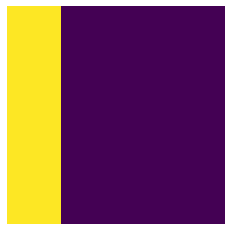

Pipetting 5.0 µl into this block:


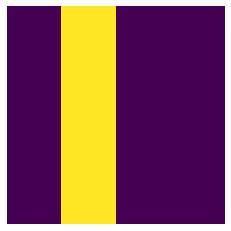

Pipetting 5.0 µl into this block:


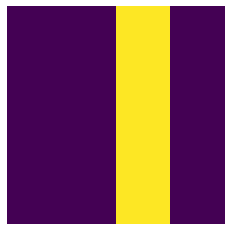

Pipetting 5.0 µl into this block:


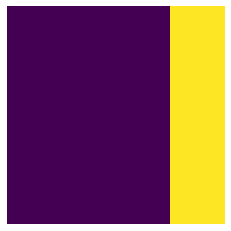

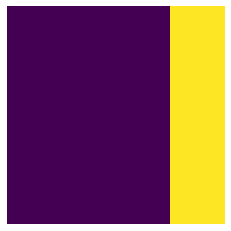

In [518]:
pip.flow_rate.aspirate = 3
pip.flow_rate.dispense = 3


for i, p in enumerate(protein.fluids):
    
    from_column = i * len(other_params.fluids)
    to_column = from_column + len(other_params.fluids)
    to_row = len(salt_buffers.fluids) * len(acids.fluids)

    print(f'Pipetting {p.well_volume} µl into this block:')
    wells_mask[:] = False
    wells_mask[0:to_row,from_column:to_column] = True
    draw_progress(wells_mask)
    

    wells = all_wells[wells_mask]    
#     print(wells_mask)
    
#     print(wells.reshape(-1,2).flatten(order='F'))
    
    if not pip.hw_pipette["has_tip"]:
        pip.pick_up_tip()

    if p.well_volume > 0:
        for well in wells.flatten():
            if not pip.hw_pipette["has_tip"]:
                pip.pick_up_tip()
            
#             well_dict[well]["protein"] = {"v": p.well_volume,
#                                      "name": p.name
#                                            }
            
            pip.aspirate(p.well_volume,
                        p.pos)
            
            pip.dispense(p.well_volume,
                        well)
#             pip.mix(3, p.well_volume*2)
            pip.drop_tip()

In [519]:

for line in protocol.commands():
    print(line)
protocol.clear_commands()

Picking up tip from A1 of Opentrons 96 Filter Tip Rack 20 µL on 8
Aspirating 5.0 uL from A1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6 at 3.0 uL/sec
Dispensing 5.0 uL into C4 of Corning 384 Well Plate 112 µL Flat on 5 at 3.0 uL/sec
Dropping tip into A1 of Opentrons Fixed Trash on 12
Picking up tip from B1 of Opentrons 96 Filter Tip Rack 20 µL on 8
Aspirating 5.0 uL from A1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6 at 3.0 uL/sec
Dispensing 5.0 uL into C5 of Corning 384 Well Plate 112 µL Flat on 5 at 3.0 uL/sec
Dropping tip into A1 of Opentrons Fixed Trash on 12
Picking up tip from C1 of Opentrons 96 Filter Tip Rack 20 µL on 8
Aspirating 5.0 uL from A1 of Opentrons 24 Tube Rack with Eppendorf 1.5 mL Safe-Lock Snapcap on 6 at 3.0 uL/sec
Dispensing 5.0 uL into C6 of Corning 384 Well Plate 112 µL Flat on 5 at 3.0 uL/sec
Dropping tip into A1 of Opentrons Fixed Trash on 12
Picking up tip from D1 of Opentrons 96 Filter Tip Rack 20 µL on 

In [107]:

pip300.drop_tip()

<InstrumentContext: p300_single_v2.1 in LEFT>

In [109]:
protocol.home()

In [105]:
pip.flow_rate.dispense

7.56

In [ ]:
flow_rate.aspirate = 50